In [1]:
import tensorflow as tf
from losses import binary_crossentropy 
from tensorflow.keras.utils import plot_model
from eunet import build_EUNet, get_callbacks
from loading_preprocessing_dataset import prepare_dataset, create_dataset
from loading_preprocessing_dataset import gaussian_filter, find_threshold_otsu, binary
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18279905121389754804,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3228529322101091823
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6290306496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 234805444929210328
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9561536089558775631
 physical_device_desc: "device: XLA_GPU device"]

## 1. Build Efficient U-Net 

In [3]:
model = build_EUNet(number_classes = 1, input_height = 256, input_width = 256)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][0]          

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0113868 to fit



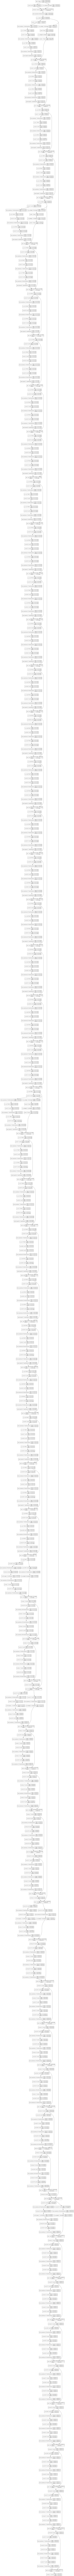

In [5]:
plot_model( model,
            to_file='model.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=4048)

In [6]:
model.compile("adam", loss=binary_crossentropy)

## 2. Load and Prepare Train, Validation and Test Datasets

In [7]:
Train_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/"
Valid_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/"
Test_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/"

In [8]:
train_sb_dir, train_gt_dir, sb_train_list, gt_train_list = prepare_dataset(Train_Dataset_dir) #load Satellite und Ground Truths Data
valid_sb_dir, valid_gt_dir, sb_valid_list, gt_valid_list = prepare_dataset(Valid_Dataset_dir)
test_sb_dir, test_gt_dir, sb_test_list, gt_test_list = prepare_dataset(Test_Dataset_dir)

Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_SB/
Number of  ground truths: 6876

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_GT/
Number der satellien images: 6876
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_SB/
Number of  ground truths: 756

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_GT/
Number der satellien images: 756
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_SB/
Number of  ground truths: 774

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_GT/
Number der satellien images: 774
*********************************************


In [9]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
number_batches = 32 #
buffer_size =  20000

In [10]:
train_dataset = create_dataset(sb_train_list, gt_train_list, buffer_size =  buffer_size, number_batche = number_batches )
validation_dataset = create_dataset(sb_valid_list, gt_valid_list, buffer_size =  buffer_size, number_batche = number_batches )
test_dataset = create_dataset(sb_test_list, gt_test_list, buffer_size =  buffer_size, number_batche = number_batches )

(32, 256, 256, 3) (32, 256, 256, 1)


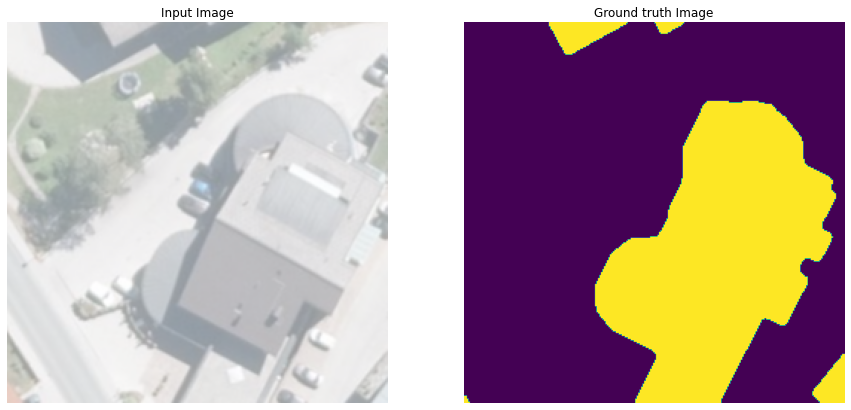

In [11]:
for SB, GT in validation_dataset.take(1):
    plt.figure(figsize=(15,15))
    print(SB.shape, GT.shape)
    display_list=[SB[0,:,:,:,],GT[0,:,:,:,]]
    title = ['Input Image', 'Ground truth Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*.5+.5 )
        plt.axis('off')
    plt.show()

## 3. Train Model

In [12]:
callbacks_list = get_callbacks()
model.fit(train_dataset,
          epochs= 100,
          verbose=1,
          callbacks=callbacks_list,
          validation_data= validation_dataset)

Epoch 1/100
215/215 [==============================] - ETA: 0s - loss: 0.8936
Epoch 00001: val_loss improved from inf to 0.64028, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/assets
215/215 [==============================] - 158s 735ms/step - loss: 0.8936 - val_loss: 0.6403
Epoch 2/100
215/215 [==============================] - ETA: 0s - loss: 0.6295
Epoch 00002: val_loss improved from 0.64028 to 0.58831, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/assets
215/215 [==============================] - 146s 679ms/step - loss: 0.6295 - val_loss: 0.5883
Epoch 3/100
215/215 [==============================] - ETA: 0s - loss: 0.5941
Epoch 00003: val_loss improved from 0.58831 to 0.54984, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
INF

Epoch 23/100
215/215 [==============================] - ETA: 0s - loss: 0.4033
Epoch 00023: val_loss improved from 0.34666 to 0.32767, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/assets
215/215 [==============================] - 148s 690ms/step - loss: 0.4033 - val_loss: 0.3277
Epoch 24/100
215/215 [==============================] - ETA: 0s - loss: 0.3783
Epoch 00024: val_loss improved from 0.32767 to 0.28872, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/assets
215/215 [==============================] - 151s 704ms/step - loss: 0.3783 - val_loss: 0.2887
Epoch 25/100
215/215 [==============================] - ETA: 0s - loss: 0.3540
Epoch 00025: val_loss improved from 0.28872 to 0.26912, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/as

INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/assets
215/215 [==============================] - 152s 707ms/step - loss: 0.1955 - val_loss: 0.1393
Epoch 49/100
215/215 [==============================] - ETA: 0s - loss: 0.1903
Epoch 00049: val_loss improved from 0.13928 to 0.13893, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/assets
215/215 [==============================] - 151s 702ms/step - loss: 0.1903 - val_loss: 0.1389
Epoch 50/100
215/215 [==============================] - ETA: 0s - loss: 0.1915
Epoch 00050: val_loss improved from 0.13893 to 0.13374, saving model to ./models/E_UNet_(12-31-2020 , 09:01:57)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 09:01:57)/assets
215/215 [==============================] - 152s 708ms/step - loss: 0.1915 - val_loss: 0.1337
Epoch 51/100
215/215 [==============================] - ETA: 0s - loss: 0.1895
Epoch 00051: v

Epoch 82/100
215/215 [==============================] - ETA: 0s - loss: 0.1426
Epoch 00082: val_loss did not improve from 0.12041
215/215 [==============================] - 103s 481ms/step - loss: 0.1426 - val_loss: 0.1405
Epoch 83/100
215/215 [==============================] - ETA: 0s - loss: 0.1414
Epoch 00083: val_loss did not improve from 0.12041
215/215 [==============================] - 102s 475ms/step - loss: 0.1414 - val_loss: 0.1305
Epoch 84/100
215/215 [==============================] - ETA: 0s - loss: 0.1429
Epoch 00084: val_loss did not improve from 0.12041
215/215 [==============================] - 102s 474ms/step - loss: 0.1429 - val_loss: 0.1331
Epoch 85/100
215/215 [==============================] - ETA: 0s - loss: 0.1411
Epoch 00085: val_loss did not improve from 0.12041
215/215 [==============================] - 102s 473ms/step - loss: 0.1411 - val_loss: 0.1356
Epoch 86/100
215/215 [==============================] - ETA: 0s - loss: 0.1376
Epoch 00086: val_loss did not

In [13]:
model_path = "./models/E_UNet_(12-31-2020 , 09:01:57)"

# load model
model = load_model(model_path)

## 4. Test Model

(32, 256, 256, 3) (32, 256, 256, 1)


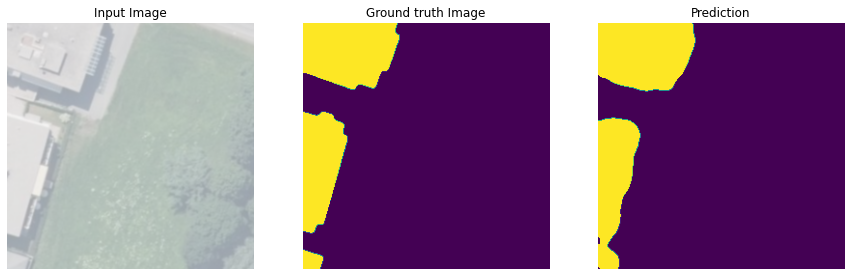

(32, 256, 256, 3) (32, 256, 256, 1)


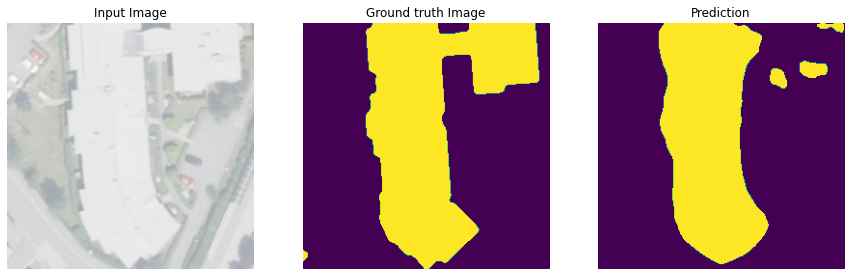

(32, 256, 256, 3) (32, 256, 256, 1)


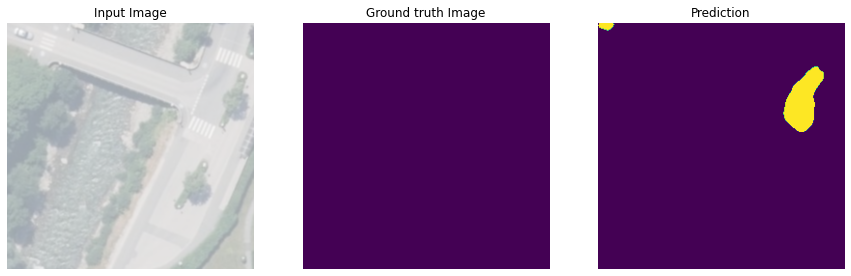

(32, 256, 256, 3) (32, 256, 256, 1)


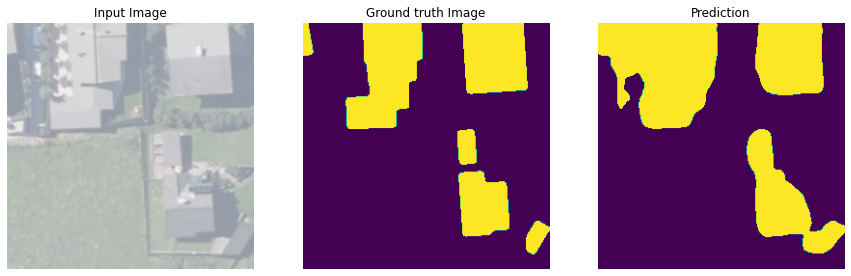

(32, 256, 256, 3) (32, 256, 256, 1)


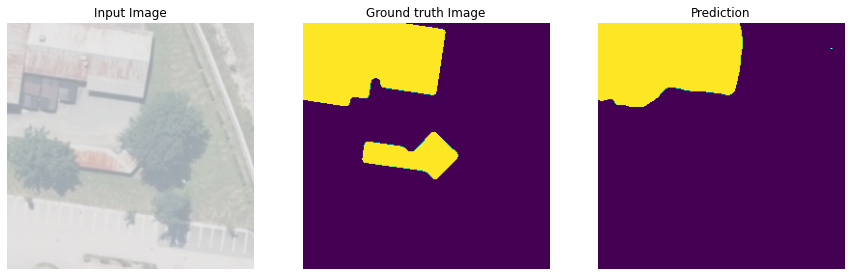

(32, 256, 256, 3) (32, 256, 256, 1)


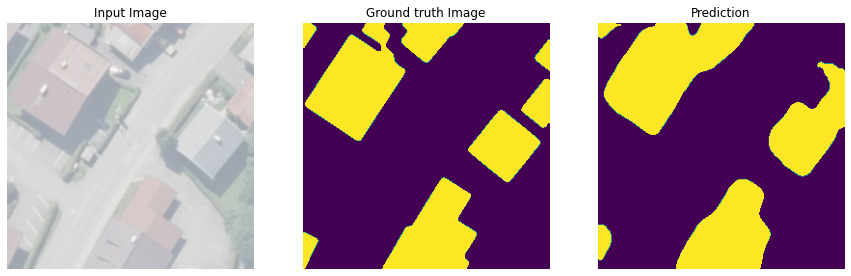

(32, 256, 256, 3) (32, 256, 256, 1)


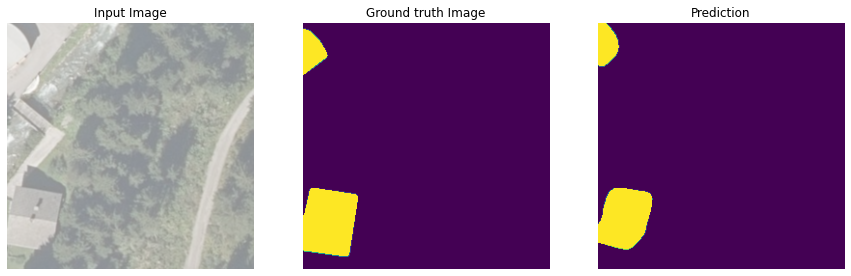

(32, 256, 256, 3) (32, 256, 256, 1)


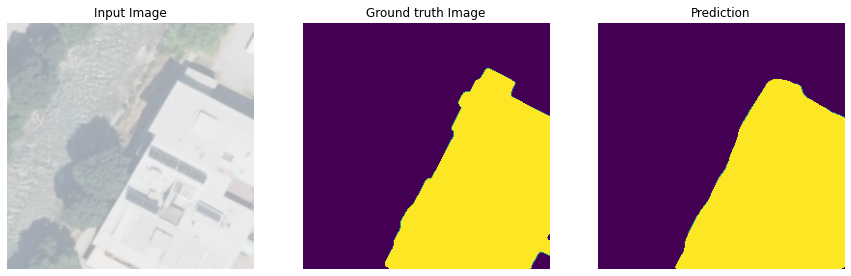

(32, 256, 256, 3) (32, 256, 256, 1)


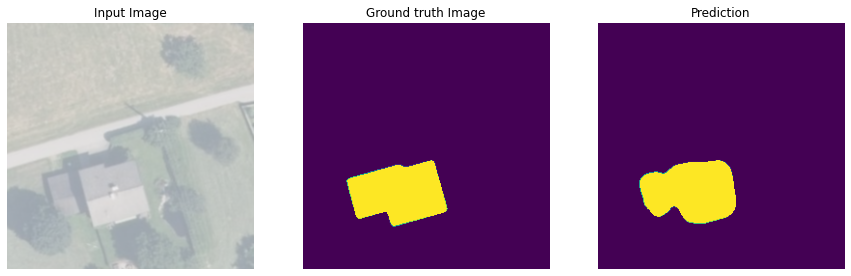

(32, 256, 256, 3) (32, 256, 256, 1)


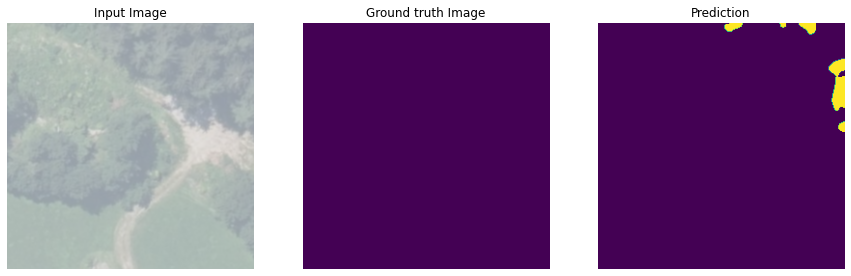

(32, 256, 256, 3) (32, 256, 256, 1)


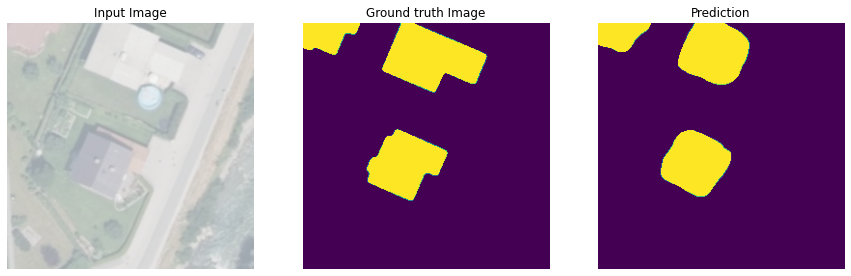

(32, 256, 256, 3) (32, 256, 256, 1)


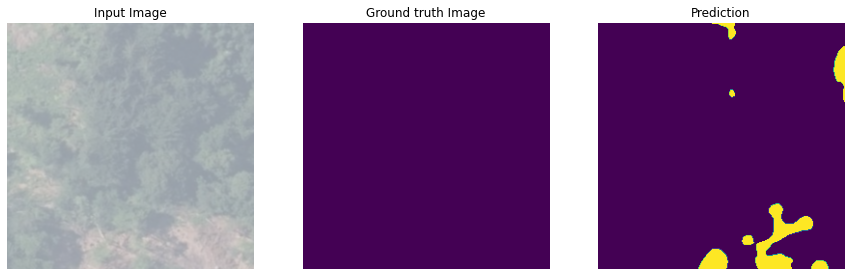

(32, 256, 256, 3) (32, 256, 256, 1)


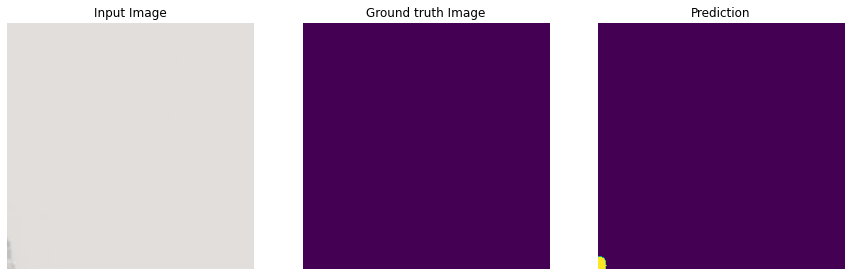

(32, 256, 256, 3) (32, 256, 256, 1)


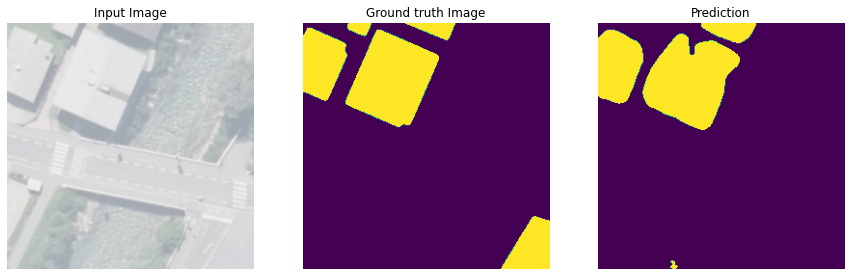

(32, 256, 256, 3) (32, 256, 256, 1)


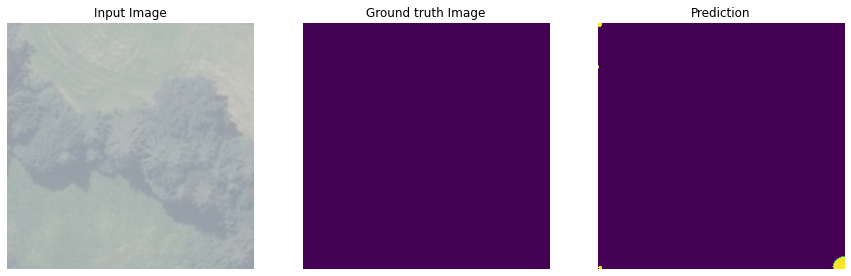

(32, 256, 256, 3) (32, 256, 256, 1)


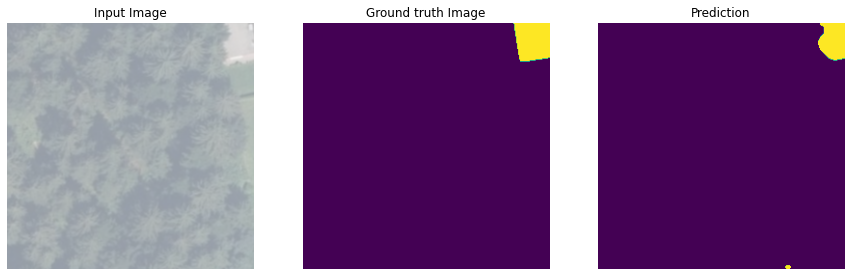

(32, 256, 256, 3) (32, 256, 256, 1)


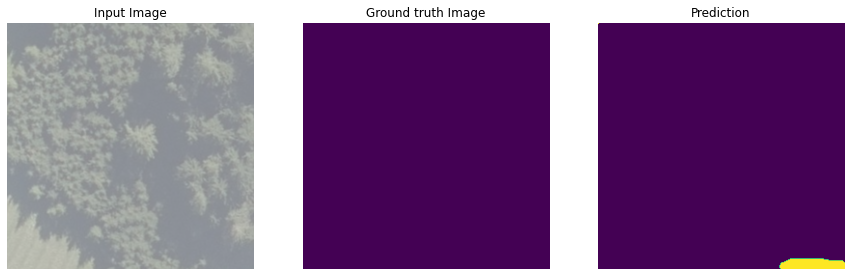

(32, 256, 256, 3) (32, 256, 256, 1)


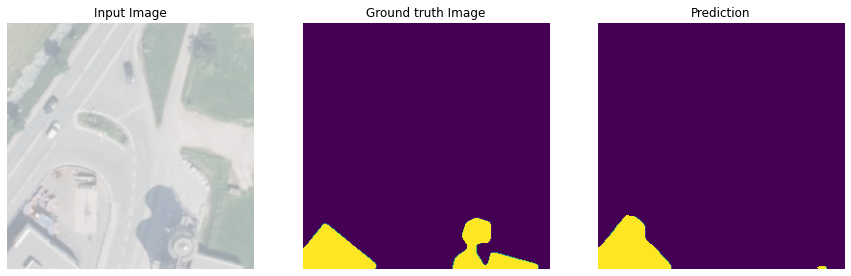

(32, 256, 256, 3) (32, 256, 256, 1)


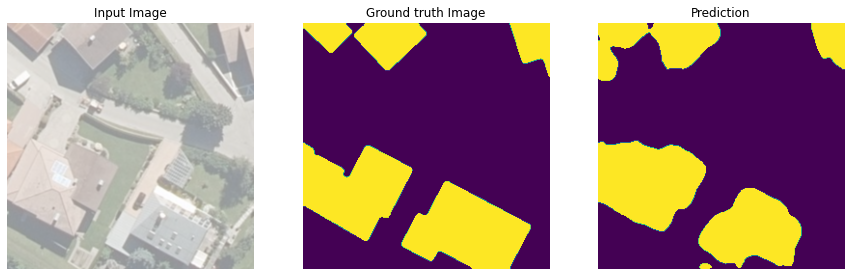

(32, 256, 256, 3) (32, 256, 256, 1)


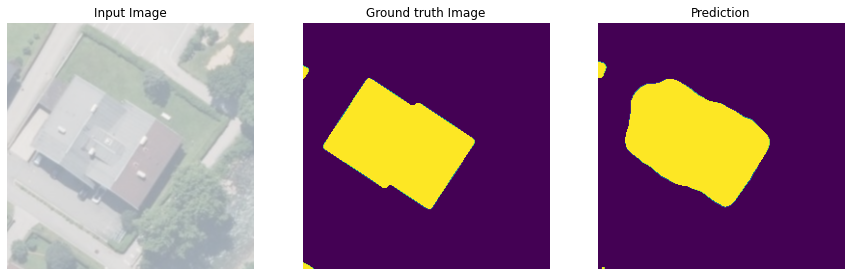

(32, 256, 256, 3) (32, 256, 256, 1)


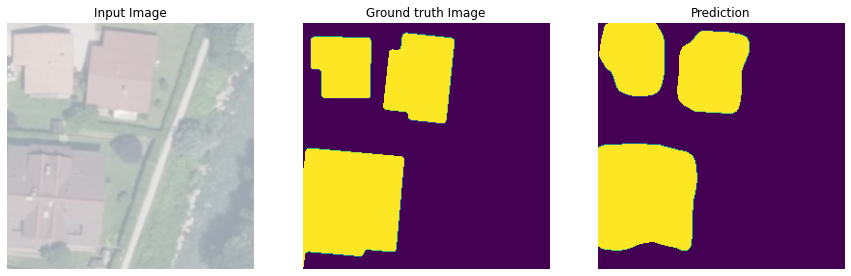

(32, 256, 256, 3) (32, 256, 256, 1)


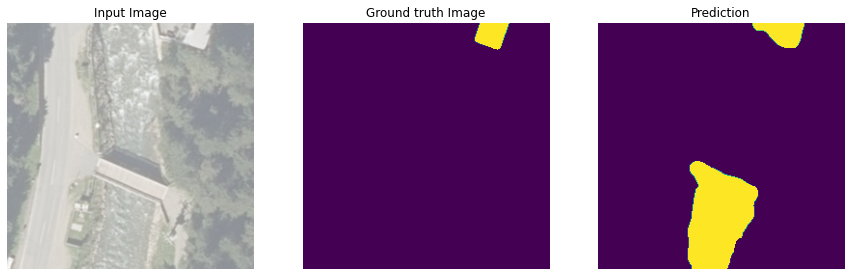

(32, 256, 256, 3) (32, 256, 256, 1)


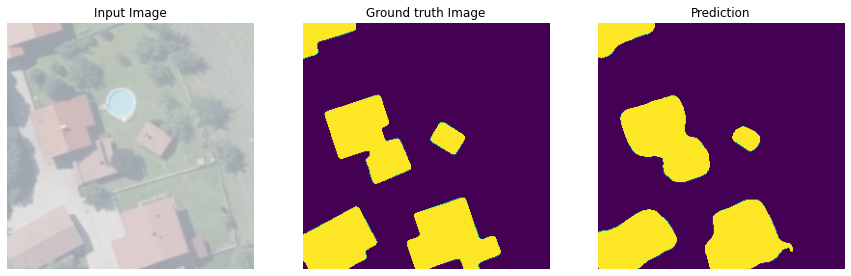

(32, 256, 256, 3) (32, 256, 256, 1)


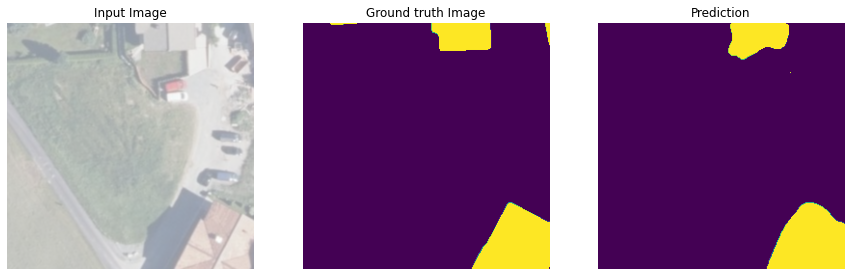

(6, 256, 256, 3) (6, 256, 256, 1)


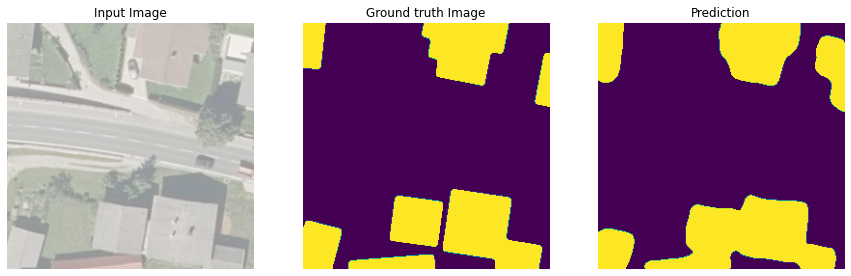

In [14]:
for SB, GT in test_dataset.take(30):
    prediction = model.predict(SB)
    plt.figure(figsize=(15,15))
    print(SB.shape, GT.shape)
    
    guass_img = gaussian_filter(prediction[0,:,:,:,], sigma =2)
    threshold =  find_threshold_otsu(guass_img)
    binary_prediction = binary(guass_img, threshold, max_value = 1)
    
    display_list=[SB[0,:,:,:,],GT[0,:,:,:,],binary_prediction]
    title = ['Input Image', 'Ground truth Image',"Prediction"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*.5+.5 )
        plt.axis('off')
    plt.show()